In [12]:
import sys
import geopandas
from pathlib import Path
import os
import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import aves
from aves.features.geo import to_point_geodataframe
from r5py import TravelTimeMatrixComputer, TransitMode, LegMode
from r5py import TransportNetwork
import datetime

In [13]:
mycrs='epsg:32719'

In [14]:
# se ajusta la memoria máxima a utilizar
# (por defecto usa el 80% de la memoria disponible)
sys.argv.append(["--max-memory", "2G"])

In [15]:
deptos_init = "../web-scrapper/portalinmobiliario.com/data/gran_santiago_total/gransantiago_prices.csv" # reemplazar por el archivo definitivo
deptos_init_df = pd.read_csv(deptos_init)
deptos_init_df.head()

direccion    precio  \
0  Avenida Pedro De Valdivia 3300 - 3600, Ñuñoa, ...  690000.0   
1  Santa Victoria 9300 - 9600, La Florida, Chile,...  650000.0   
2  Avenida Irarrázaval 4800 - 5100, Ñuñoa, Chile,...  650000.0   
3  Avenida Manquehue Norte 900 - 1200, Las Condes...  733000.0   
4  Avenida Manquehue Norte 900 - 1200, Las Condes...  810000.0   

                         gastos_comunes  \
0  Gastos comunes aproximados $ 120.000   
1  Gastos comunes aproximados $ 100.000   
2  Gastos comunes aproximados $ 130.000   
3  Gastos comunes aproximados $ 150.000   
4  Gastos comunes aproximados $ 125.000   

                            caracteristicas  num_caracteristicas  \
0                                       NaN                    0   
1   66 m² totales / 3 dormitorios / 2 baños                    3   
2   60 m² totales / 2 dormitorios / 2 baños                    3   
3  45.91 m² totales / 1 dormitorio / 1 baño                    3   
4  48.09 m² totales / 1 dormitorio / 1 baño                    3   

  fecha_descarga        fecha_publicacion  \
0     2023-06-13   Publicado hace 32 días   
1     2023-06-13   Publicado hace 27 días   
2     2023-06-13   Publicado hace 2 meses   
3     2023-06-13  Publicado hace 11 meses   
4     2023-06-13     Publicado hace 1 año   

                                              titulo  \
0  ¡ Semi Amoblado ! Departamento 2d Y 2d (m) En ...   
1            Departamento 3d Y 2b En Santa Victoria.   
2  Departamento 2d Y 2b En Irarrazaval. Metro Vil...   
3     Departamento Nuevo 1d1b, Insuperable Ubicación   
4    Departamento Nuevo 1d1b, Insuperable Ubicación    

                                                 url    latitud   longitud  \
0  https://www.portalinmobiliario.com/MLC-1383721... -33.455824 -70.605074   
1  https://www.portalinmobiliario.com/MLC-1676897... -33.537729 -70.554861   
2  https://www.portalinmobiliario.com/MLC-1430206... -33.453552 -70.571432   
3  https://www.portalinmobiliario.com/MLC-1359792... -33.399006 -70.571399   
4  https://www.portalinmobiliario.com/MLC-1385350... -33.399006 -70.571399   

     ciudad           precio_range  
0  Santiago  (500000.0, 1000000.0]  
1  Santiago  (500000.0, 1000000.0]  
2  Santiago  (500000.0, 1000000.0]  
3  Santiago  (500000.0, 1000000.0]  
4  Santiago  (500000.0, 1000000.0]

In [16]:
# y agregamos la columna id que será necesaria más tarde
deptos_init_df["id"] = deptos_init_df.index
deptos_init_df.head()

direccion    precio  \
0  Avenida Pedro De Valdivia 3300 - 3600, Ñuñoa, ...  690000.0   
1  Santa Victoria 9300 - 9600, La Florida, Chile,...  650000.0   
2  Avenida Irarrázaval 4800 - 5100, Ñuñoa, Chile,...  650000.0   
3  Avenida Manquehue Norte 900 - 1200, Las Condes...  733000.0   
4  Avenida Manquehue Norte 900 - 1200, Las Condes...  810000.0   

                         gastos_comunes  \
0  Gastos comunes aproximados $ 120.000   
1  Gastos comunes aproximados $ 100.000   
2  Gastos comunes aproximados $ 130.000   
3  Gastos comunes aproximados $ 150.000   
4  Gastos comunes aproximados $ 125.000   

                            caracteristicas  num_caracteristicas  \
0                                       NaN                    0   
1   66 m² totales / 3 dormitorios / 2 baños                    3   
2   60 m² totales / 2 dormitorios / 2 baños                    3   
3  45.91 m² totales / 1 dormitorio / 1 baño                    3   
4  48.09 m² totales / 1 dormitorio / 1 baño                    3   

  fecha_descarga        fecha_publicacion  \
0     2023-06-13   Publicado hace 32 días   
1     2023-06-13   Publicado hace 27 días   
2     2023-06-13   Publicado hace 2 meses   
3     2023-06-13  Publicado hace 11 meses   
4     2023-06-13     Publicado hace 1 año   

                                              titulo  \
0  ¡ Semi Amoblado ! Departamento 2d Y 2d (m) En ...   
1            Departamento 3d Y 2b En Santa Victoria.   
2  Departamento 2d Y 2b En Irarrazaval. Metro Vil...   
3     Departamento Nuevo 1d1b, Insuperable Ubicación   
4    Departamento Nuevo 1d1b, Insuperable Ubicación    

                                                 url    latitud   longitud  \
0  https://www.portalinmobiliario.com/MLC-1383721... -33.455824 -70.605074   
1  https://www.portalinmobiliario.com/MLC-1676897... -33.537729 -70.554861   
2  https://www.portalinmobiliario.com/MLC-1430206... -33.453552 -70.571432   
3  https://www.portalinmobiliario.com/MLC-1359792... -33.399006 -70.571399   
4  https://www.portalinmobiliario.com/MLC-1385350... -33.399006 -70.571399   

     ciudad           precio_range  id  
0  Santiago  (500000.0, 1000000.0]   0  
1  Santiago  (500000.0, 1000000.0]   1  
2  Santiago  (500000.0, 1000000.0]   2  
3  Santiago  (500000.0, 1000000.0]   3  
4  Santiago  (500000.0, 1000000.0]   4

<Axes: >

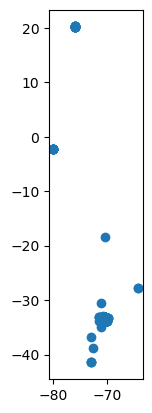

In [17]:
deptos = to_point_geodataframe(deptos_init_df, 'longitud', 'latitud', crs=mycrs)
deptos.plot()

In [18]:
# para sacar las coordenadas de la dirección de destino
# se toma un punto de destino: el del viaje más frecuente
direccion_destino_2 = "Capitán Ignacio Carrera Pinto 1045,Santiago, RM (Metropolitana)"
max_tries = 10
retry_timeout = 5  # Timeout in seconds

latitude = -33.467990
longitude = -70.593740
print(latitude)
print(longitude)
destino_df_2 = pd.DataFrame(
    {"direccion": direccion_destino_2,
     "latitud": latitude,
     "longitud": longitude},
     index=[14996]
)
destino_df_2["id"] = destino_df_2.index
destino_2= to_point_geodataframe(destino_df_2, "longitud", "latitud", crs=mycrs)
destino_2


-33.46799
-70.59374


direccion   latitud  longitud  \
14996  Capitán Ignacio Carrera Pinto 1045,Santiago, R... -33.46799 -70.59374   

          id                 geometry  
14996  14996  POINT (-70.594 -33.468)

In [19]:
transport_network = TransportNetwork(
    "clipped-scl-osm.pbf", ["santiago_dptm_gtfs.zip"]
)

In [20]:
travel_time_matrix_computer_points = TravelTimeMatrixComputer(
    transport_network,
    origins=deptos,
    destinations=destino_2,
    departure=datetime.datetime(2023, 7, 3, 18, 0), # esta hora también la debería ingresar el usuario
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
    breakdown=True
)

travel_time_matrix_detailed_points = travel_time_matrix_computer_points.compute_travel_times()
travel_time_matrix_detailed_points

/home/ignacio/miniconda3/envs/aves/lib/python3.9/site-packages/r5py/r5/regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
/home/ignacio/miniconda3/envs/aves/lib/python3.9/site-packages/r5py/r5/regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
/home/ignacio/miniconda3/envs/aves/lib/python3.9/site-packages/r5py/r5/regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
/home/ignacio/miniconda3/envs/aves/lib/python3.9/site-packages/r5py/r5/regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and wi

from_id  to_id  travel_time                routes  \
0         0  14996         25.0             [L3, 224]   
0         1  14996         65.0  [E07, L4V, D16, 325]   
0         2  14996         29.0                 [106]   
0         3  14996         54.0    [C07, L1, L6, 126]   
0         4  14996         61.0    [C06, L1, L6, 508]   
..      ...    ...          ...                   ...   
0     14990  14996         83.0        [MTN, L6, 519]   
0     14991  14996         57.0   [H14, L2V, L6, 126]   
0     14992  14996         53.0    [L1, L2R, L6, 106]   
0     14993  14996         40.0             [L3, 104]   
0     14994  14996         42.0       [204, 506, 325]   

                   board_stops               alight_stops  \
0                 [106, PD107]                [118, PD61]   
0   [PE402, 98, PD1356, PD638]  [PE151, 84, PD638, PD915]   
0                      [PD108]                     [PD61]   
0       [PC103, 58, 41, PD529]     [PC105, 41, 105, PD61]   
0       [PB104, 93, 41, PD529]    [PC738, 41, 105, PD530]   
..                         ...                        ...   
0         [PT0220, 102, PD115]       [PT0212, 105, PD590]   
0       [PH788, 19, 29, PD529]     [PH127, 29, 105, PD61]   
0           [2, 44, 29, PD529]        [44, 29, 105, PD61]   
0                  [12, PD107]                [118, PD61]   
0        [PA117, PA440, PD530]      [PA121, PD590, PD892]   

               ride_times  access_time  egress_time  transfer_time  \
0              [1.4, 5.4]          1.8         11.1            2.0   
0   [21.0, 7.3, 8.2, 5.0]          6.1          3.6            3.6   
0                  [13.9]          2.5         11.1            0.0   
0    [3.7, 6.7, 7.0, 3.0]          5.1         11.1            8.5   
0   [18.1, 1.0, 7.0, 3.1]          6.3         12.0            6.0   
..                    ...          ...          ...            ...   
0       [18.4, 12.6, 4.8]         23.6         11.3            5.7   
0    [8.0, 4.6, 7.3, 3.0]          5.8         11.1            6.6   
0    [6.0, 4.3, 7.3, 2.9]          8.3         11.1            4.0   
0             [15.1, 6.6]          2.4         11.1            2.0   
0        [5.3, 17.0, 1.8]          0.3          4.7            2.2   

              wait_times  total_time n_iterations  
0             [1.4, 4.4]        27.4            2  
0   [5.0, 1.3, 2.7, 1.0]        64.9            1  
0                  [3.3]        30.9            9  
0   [3.8, 2.4, 3.6, 2.4]        57.3            3  
0   [3.1, 2.5, 1.3, 1.9]        62.2            1  
..                   ...         ...          ...  
0        [2.3, 4.7, 1.4]        84.7            1  
0   [1.4, 2.3, 1.3, 2.5]        53.9            2  
0   [1.9, 1.6, 2.2, 3.4]        53.1            1  
0             [5.3, 1.4]        44.0            2  
0        [4.6, 4.9, 2.0]        42.9            1  

[14995 rows x 13 columns]

In [21]:
travel_time_matrix_detailed_points.to_csv('./'+'travel_time_matrix_detailed_alldeptos_to_jgm_deportivo.csv',index=False)